In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [3]:
project_id = 'qwiklabs-gcp-00-ac2bc8014940'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [4]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [12]:
# prompt: Convert the table ecommerce.customer_stats to a BigQuery DataFrames dataframe and show the top 10 records
df = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,5456,781,3,74.083334
1,23723,861,4,38.87
2,31793,927,1,40.0
3,73288,849,1,44.0
4,18495,806,2,30.475
5,83310,617,1,109.989998
6,64752,646,1,68.949997
7,12666,865,2,41.225
8,41855,942,1,41.950001
9,5557,842,1,44.5


In [14]:
#prompt: 1. Split df into test and training data for a K-means clustering algorithm store these as df_test_ and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model to BigQuery in a model called ecommerce.model_name using the to_gbq method.

df_train, df_test = train_test_split(df, test_size=0.2,  random_state=42)
model = KMeans(n_clusters=5)
model.fit(df_train)
model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [15]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = model.predict(df)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.869710992895...",5456,781,3,74.083334
1,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.755927640065...",23723,861,4,38.87
2,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.831567933965...",31793,927,1,40.0
3,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.950716599642...",73288,849,1,44.0
4,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.988958455004...",18495,806,2,30.475
5,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.838420528364...",83310,617,1,109.989998
6,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.214886994867...",64752,646,1,68.949997
7,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.440791735618...",12666,865,2,41.225
8,4,"[{'CENTROID_ID': 4, 'DISTANCE': 2.046749951785...",41855,942,1,41.950001
9,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.209302547675...",5557,842,1,44.5


Exception ignored in: <generator object RowIterator._to_page_iterable at 0x7b539054f060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/table.py", line 1809, in _to_page_iterable
    yield from result_pages
  File "/usr/local/lib/python3.10/dist-packages/google/cloud/bigquery/_pandas_helpers.py", line 940, in _download_table_bqstorage
    pool.shutdown(wait=True)
  File "/usr/lib/python3.10/concurrent/futures/thread.py", line 235, in shutdown
    t.join()
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt: 


Requested cancellation for Query job 5a7460cd-3155-4b47-b368-b873b7f854c1 in location US...


KeyboardInterrupt: 

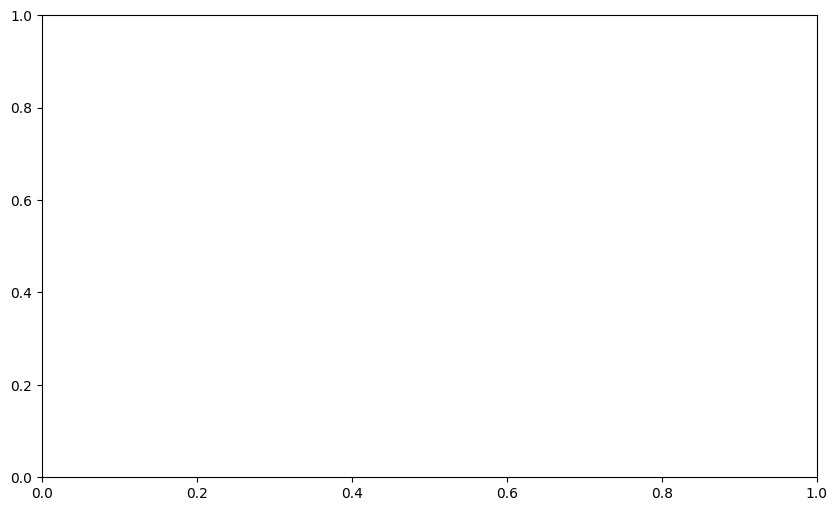

In [18]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='Cluster ID')
plt.show()

In [19]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,44.18,1.27,754.07
1,cluster 2,387.10,1.18,761.65
2,cluster 3,162.00,1.29,739.84
3,cluster 4,43.84,1.29,740.60
4,cluster 5,58.10,3.68,716.86


In [20]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $44.18, count of orders per person 1.27, days since last order 754.07
cluster 2, average spend $387.1, count of orders per person 1.18, days since last order 761.65
cluster 3, average spend $162.0, count of orders per person 1.29, days since last order 739.84
cluster 4, average spend $43.84, count of orders per person 1.29, days since last order 740.6
cluster 5, average spend $58.1, count of orders per person 3.68, days since last order 716.86


In [21]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [22]:
#prompt:  Use the Vertex AI language_models API to call the PaLM2 text-bison model and generate a marketing campaign using the variable prompt. Use the following model settings: max_output_tokens=1024, temperature=0.4

model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(prompt, max_output_tokens=1024, temperature=0.4)
print(response.text)

 **Cluster 1: The Occasional Treaters**

* **Title:** The Occasional Treaters
* **Persona:** These customers are not frequent shoppers, but when they do make a purchase, they tend to spend a bit more. They may be looking for a special treat or a gift for someone else.
* **Next marketing step:** Target these customers with personalized emails or social media ads featuring high-quality images of your products and special offers.

**Cluster 2: The Loyalists**

* **Title:** The Loyalists
* **Persona:** These customers are your bread and butter. They shop frequently and spend a lot of money. They are likely to be loyal to your brand and are more likely to make repeat purchases.
* **Next marketing step:** Reward these customers for their loyalty with a loyalty program or exclusive discounts.

**Cluster 3: The Bargain Hunters**

* **Title:** The Bargain Hunters
* **Persona:** These customers are looking for a good deal. They may be price-sensitive or they may be looking for a specific product